# Assignment 1 - Modelling

## Model and objectives
- Draw the plan of a two-zone building.
- Formulate the hypothesis for boundary conditions.
- Choose the types of windows, doors, and walls.
- Draw the thermal circuit:
temperature nodes,
flow-rate paths,
thermal conductances for conduction, convection, long-wave radiation, advection, and P-controllers,
sources of temperature and flow-rate,
- Number the temperature nodes and the flow-rate branches (starting from 0).
- Calculate the thermal conductances for conduction, convection, long-wave radiation, and advection.
- Calculate the thermal capacities.
- Write down the incidence matrix
A
, the conductance matrix
G
 and the capacity matrix
C
 of the system of Algebraic Differential Equations (DAE).
- Define the inputs: temperature sources (vector
b
) and flow rate sources (vector
f
).
- Write in Python the incidence matrix
A
, the conductance matrix
G
 and the capacity matrix
C
 of the system of Algebraic Differential Equations (DAE).
- Write in Python the vectors of pointers to the temperature sources
b
, flow-rate sources
f
, and outputs
y
.

In [ ]:
print("Smart Cities - Assignment 1")

import numpy as np
import sys
sys.path.append('/content/Code/')  # Remplacez par le chemin copié
import dm4bem
import pandas as pd
import matplotlib.pyplot as plt

Smart Cities - final project


ModuleNotFoundError: No module named 'dm4bem'

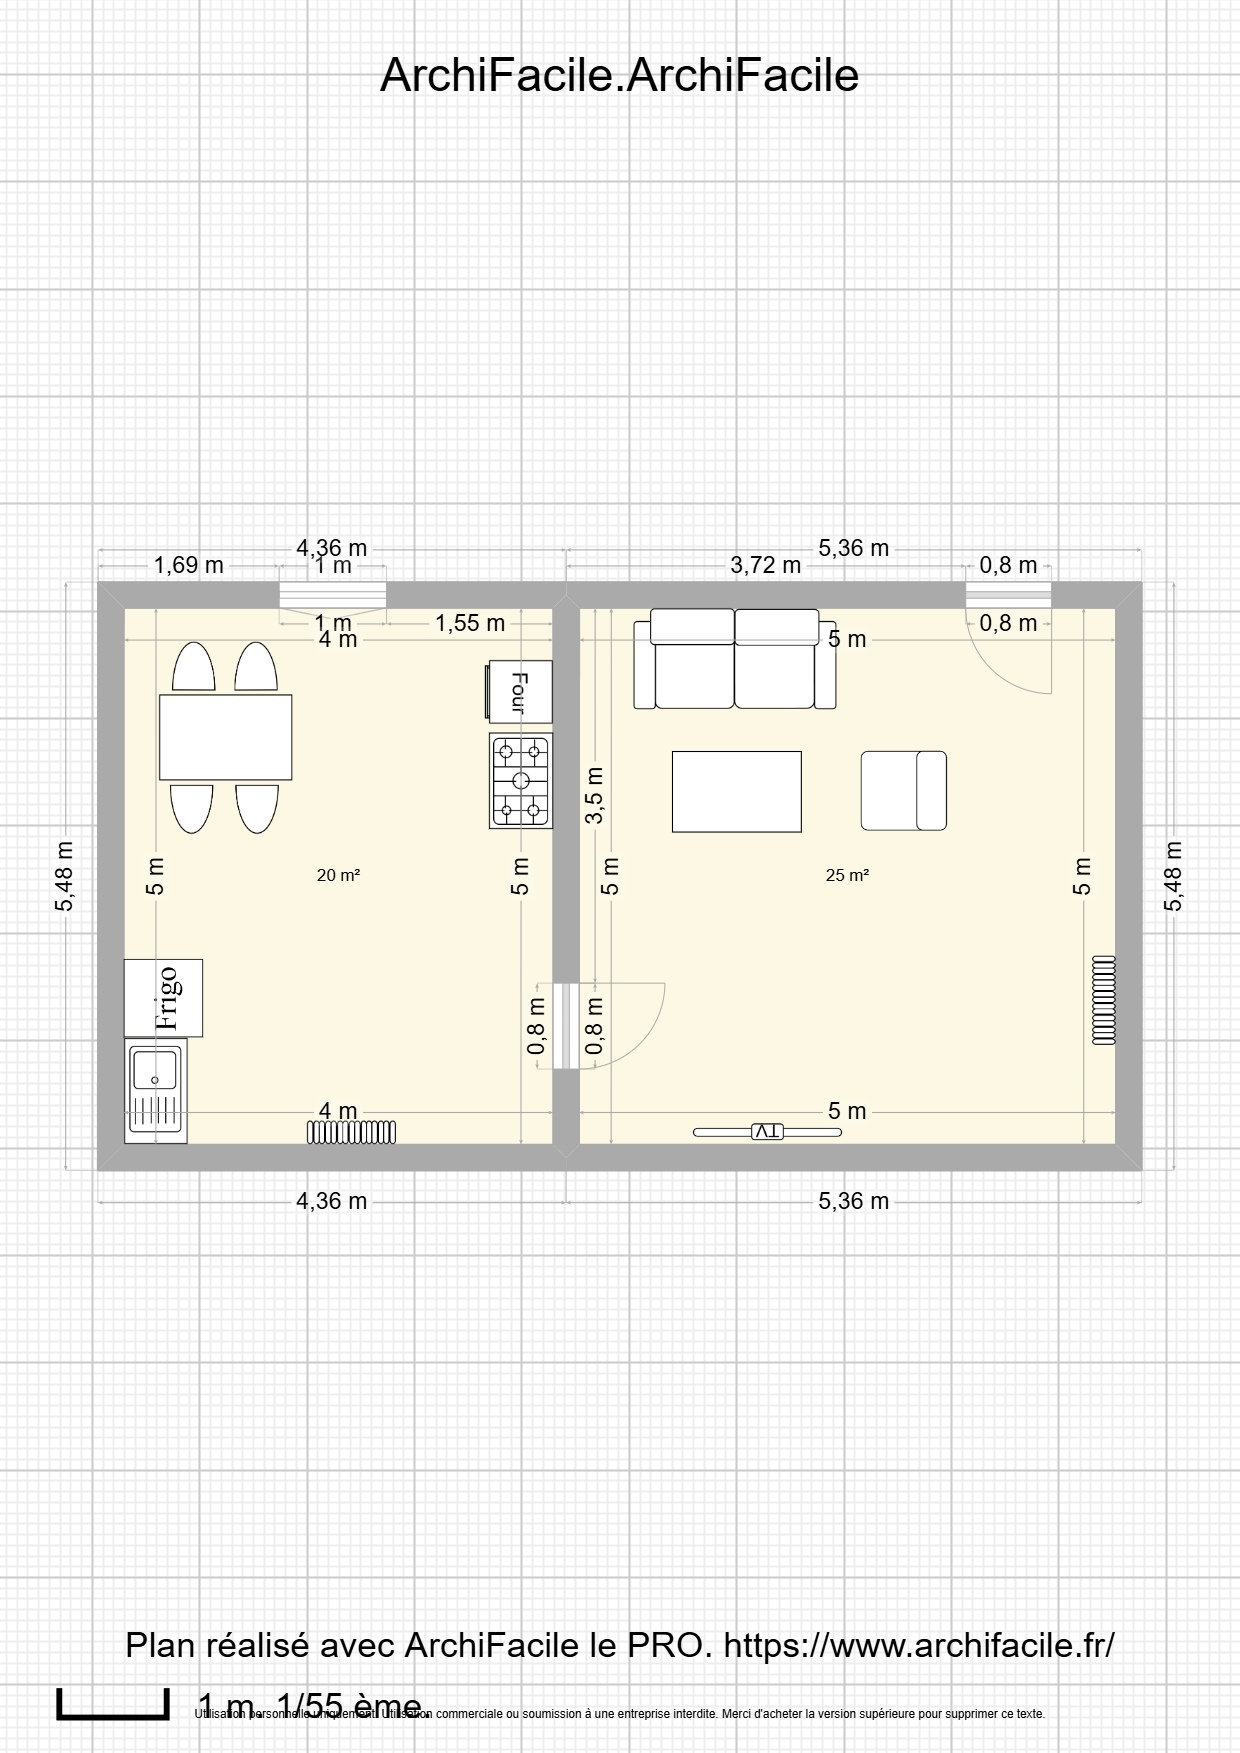

Figure 1. Simple ventilated room (5 walls, 1 glass window, 2 doors) equipped with two 2350W radiators.

**Description of the building**

In [ ]:
#Left room (1)

l1 = 4             # m width of building
L1 = 5            # m length of building
S1 = 20           # m² surface area of room
h = 2.5           # Height of walls
Sd1 = 0.8*h       # m2 door surface
Swindow = 1.5     # m2 window surface
Sw1 = 2*l1*h + 2*L1*h - Sd1 - Swindow     # m² inside surface area of concrete walls

#Right room (2)

l2 = 5            # m width of building
L2 = 5            # m length of building
S2 = 25           # m² surface area of room
h = 2.5           # Height of walls
Sd2 = 2*0.8*h      # m2 door surface
Sw2 = 2*l2*h + 2*L2*h - Sd2      # m² inside surface area of concrete walls

#Exterior (3)

Swe = 2*9*h + 2*5*h - Sd2 - Swindow #m2 exterior wall surface


**Hypothesis of boundaries**

The building has a rectangular shape, with the following thermal boundary conditions:

- East wall: adiabatic (no heat exchange).
- West wall: adiabatic.
- South wall: adiabatic.
- Only the North wall is in contact with the exterior environment and allows heat exchange.
- The ceiling and floor are also considered adiabatic, as a simplifying assumption.
- We consider the heat variation inside is uniform.

We consider the system in steady state, meaning that all temperatures are constant over time:
$\frac{dT_i}{dt} = 0 $

The heat transfer is assumed to be uniform across the entire surface of each wall. This implies that the heat flux is the same at every point on the surface. Therefore, the total heat flux through the wall can be written as:
$\dot{Q} = \frac{T_{\text{int}} - T_{\text{ext}}}{R_{\text{total}}} $


In [ ]:
#Thermal Boundaries and properties

Text = 12    # °C Constant exterior temperature
Pr = 2350    # W Thermal power of each radiator

e_w_insulation = 0.04    # m Insulation width
e_w_concrete = 0.2    # m Concrete Width
e_w = e_w_insulation + e_w_concrete    # m Wall width
e_d = 0.07    # m Wooden door width
e_window = 0.02 #m Glass window width



**Thermo-physical properties**

In [ ]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


In [ ]:
import pandas as pd

# Material properties
concrete = {'Conductivity': 1.400,           # W/(m·K)
            'Density': 2300.0,               # kg/m³
            'Specific heat': 880,            # J/(kg⋅K)
            'Width': 0.2,                    # m
            'Surface_interior': Sw1 + Sw2,   # m²
            'Surface_exterior': Swe}         # m²

insulation = {'Conductivity': 0.027,         # W/(m·K)
              'Density': 55.0,               # kg/m³
              'Specific heat': 1210,         # J/(kg⋅K)
              'Width': 0.04,                 # m
              'Surface_interior': Sw1 + Sw2} # m²

glass = {'Conductivity': 1.4,                # W/(m·K)
         'Density': 2500,                    # kg/m³
         'Specific heat': 1210,              # J/(kg⋅K)
         'Width': 0.02,                      # m
         'Surface_interior': Swindow}        # m²

wood = {'Conductivity': 0.12,                # W/(m·K)
        'Density': 600.0,                    # kg/m³
        'Specific heat': 1600,               # J/(kg⋅K)
        'Width': 0.07,                       # m
        'Surface_interior': Sd1+Sd2,
        'Surface_exterior': Sd2}           # m²

# Combine all materials into a DataFrame
wall = pd.DataFrame([concrete, insulation, glass, wood],
                    index=['Concrete', 'Insulation', 'Glass', 'Wood'])

# Display the DataFrame
wall


,Conductivity,Density,Specific heat,Width,Surface_interior,Surface_exterior
Concrete,1.400,2300.0,880,0.20,87.5,64.5
Insulation,0.027,55.0,1210,0.04,87.5,NaN
Glass,1.400,2500.0,1210,0.02,1.5,NaN
Wood,0.120,600.0,1600,0.07,6.0,4.0


**Radiative properties**

In [ ]:
# Radiative properties (long-wave and short-wave)

# Long-wave emissivity (infrared)
ε_wall_LW = 0.85    # Wall surface (e.g. concrete, insulation)
ε_glass_LW = 0.90   # Glass (e.g. Pyrex or reflective)

# Short-wave absorptivity (solar)
α_wall_SW = 0.25    # Wall surface (e.g. white paint or concrete)
α_glass_SW = 0.38   # Reflective blue glass
α_wood_SW = 0.65    # Wood (e.g. medium-brown varnish, typical range 0.6–0.7)

# Short-wave transmittance (only glass transmits)
τ_glass_SW = 0.30   # Reflective blue glass

# Optional (if needed)
# ρ_glass_SW = 1 - α_glass_SW - τ_glass_SW  # reflectance (if useful)

**The Stefan-Boltzmann constant is**:

In [ ]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

In [ ]:
# Example convection coefficients
h_in = 8      # W/(m²·K) - interior surfaces
h_out = 25    # W/(m²·K) - exterior surfaces (default)

# Create DataFrame with λ and h values
thermal_properties = pd.DataFrame([
    {
        'Material': 'Concrete',
        'Conductivity λ [W/m·K]': 1.400,
        'h_in [W/m²·K]': h_in,
        'h_out [W/m²·K]': h_out
    },
    {
        'Material': 'Insulation',
        'Conductivity λ [W/m·K]': 0.027,
        'h_in [W/m²·K]': h_in,
        'h_out [W/m²·K]': None  # Typically internal only
    },
    {
        'Material': 'Glass',
        'Conductivity λ [W/m·K]': 1.400,
        'h_in [W/m²·K]': h_in,
        'h_out [W/m²·K]': h_out  # <-- Added this
    },
    {
        'Material': 'Wood',
        'Conductivity λ [W/m·K]': 0.12,
        'h_in [W/m²·K]': h_in,
        'h_out [W/m²·K]': h_out
    }
])

# Set 'Material' as index
thermal_properties.set_index('Material', inplace=True)

# Display the table
thermal_properties

,Conductivity λ [W/m·K],h_in [W/m²·K],h_out [W/m²·K]
Material,,,
Concrete,1.400,8,25.0
Insulation,0.027,8,NaN
Glass,1.400,8,25.0
Wood,0.120,8,25.0


In [ ]:
import pandas as pd

# Geometry and areas (recomputed for clarity)
h = 2.5
l1, L1 = 4, 5
l2, L2 = 5, 5
Swindow = 1.5
Sd1 = 0.8 * h
Sd2 = 2 * 0.8 * h
Sw1 = 2 * l1 * h + 2 * L1 * h - Sd1 - Swindow
Sw2 = 2 * l2 * h + 2 * L2 * h - Sd2
Swe = 2 * 9 * h + 2 * 5 * h - Sd2 - Swindow

# Convection coefficients
h_in = 8      # W/(m²·K)
h_out = 25    # W/(m²·K)

# Material properties and areas
materials = {
    'Concrete': {
        'λ': 1.400, 'e': 0.2,
        'A_in': Sw1 + Sw2,
        'A_out': Swe
    },
    'Insulation': {
        'λ': 0.027, 'e': 0.04,
        'A_in': Sw1 + Sw2,
        'A_out': None  # no external convection
    },
    'Glass': {
        'λ': 1.4, 'e': 0.02,
        'A_in': Swindow,
        'A_out': Swindow
    },
    'Wood': {
        'λ': 0.12, 'e': 0.07,
        'A_in': Sd1 + Sd2,
        'A_out': Sd2
    }
}

# Calculate resistances
resistances = []
for mat, props in materials.items():
    A_in = props['A_in']
    A_out = props['A_out']
    R_cond = props['e'] / (props['λ'] * A_in)
    R_conv_in = 1 / (h_in * A_in)
    R_conv_out = 1 / (h_out * A_out) if A_out else None

    resistances.append({
        'Material': mat,
        'R_cond [K/W]': round(R_cond, 6),
        'R_conv,in [K/W]': round(R_conv_in, 6),
        'R_conv,out [K/W]': round(R_conv_out, 6) if R_conv_out else None
    })

# Create DataFrame
R_table = pd.DataFrame(resistances).set_index('Material')

# Display table
R_table

,R_cond [K/W],"R_conv,in [K/W]","R_conv,out [K/W]"
Material,,,
Concrete,0.001633,0.001429,0.000620
Insulation,0.016931,0.001429,NaN
Glass,0.009524,0.083333,0.026667
Wood,0.097222,0.020833,0.010000


In [ ]:
import pandas as pd

# Thermal properties for each material
thermal_data = {
    'Concrete': {
        'Density': 2300.0,        # kg/m³
        'Specific heat': 880,     # J/(kg·K)
        'Width': 0.2,             # m
        'Surface': Sw1 + Sw2      # m²
    },
    'Insulation': {
        'Density': 55.0,
        'Specific heat': 1210,
        'Width': 0.04,
        'Surface': Sw1 + Sw2
    },
    'Glass': {
        'Density': 2500,
        'Specific heat': 1210,
        'Width': 0.02,
        'Surface': Swindow
    },
    'Wood': {
        'Density': 600,
        'Specific heat': 1600,
        'Width': 0.07,
        'Surface': Sd1 + Sd2
    }
}

# Calculate thermal capacities
thermal_capacities = []
for material, props in thermal_data.items():
    rho = props['Density']
    cp = props['Specific heat']
    e = props['Width']
    S = props['Surface']
    C = rho * cp * S * e  # in J/K
    thermal_capacities.append({
        'Material': material,
        'Density [kg/m³]': rho,
        'c_p [J/(kg·K)]': cp,
        'Width [m]': e,
        'Surface [m²]': S,
        'Thermal Capacity C [J/K]': round(C, 2)
    })

# Convert to DataFrame
df_capacity = pd.DataFrame(thermal_capacities)
df_capacity.set_index('Material', inplace=True)

# Display
df_capacity


,Density [kg/m³],c_p [J/(kg·K)],Width [m],Surface [m²],Thermal Capacity C [J/K]
Material,,,,,
Concrete,2300.0,880,0.20,87.5,35420000.0
Insulation,55.0,1210,0.04,87.5,232925.0
Glass,2500.0,1210,0.02,1.5,90750.0
Wood,600.0,1600,0.07,6.0,403200.0
